# Demo of DBSCAN clustering algorithm

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) finds core samples in regions of high density and expands clusters from them. This algorithm is good for data which contains clusters of similar density.

See the Comparing different clustering algorithms on toy datasets example for a demo of different clustering algorithms on 2D datasets.

In [3]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=0.4, random_state=0
)

X = StandardScaler().fit_transform(X)

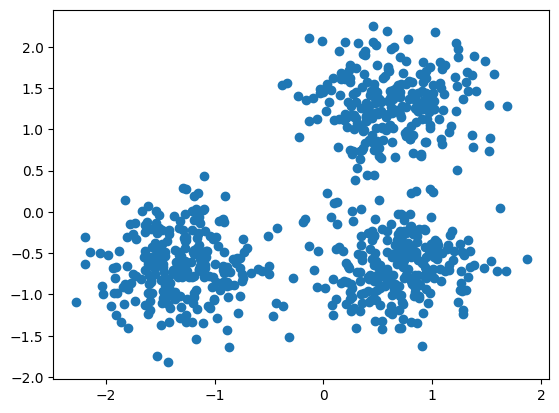

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [5]:
import numpy as np

from sklearn import metrics
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.3, min_samples=10).fit(X)
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0) # noise is given -1
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 18


Clustering algorithms are fundamentally unsupervised learning methods. However, since make_blobs gives access to the true labels of the synthetic clusters, it is possible to use evaluation metrics that leverage this “supervised” ground truth information to quantify the quality of the resulting clusters. Examples of such metrics are the homogeneity, completeness, V-measure, Rand-Index, Adjusted Rand-Index and Adjusted Mutual Information (AMI).

If the ground truth labels are not known, evaluation can only be performed using the model results itself. In that case, the Silhouette Coefficient comes in handy.

In [6]:
print(f"Homogeneity: {metrics.homogeneity_score(labels_true, labels):.3f}")
print(f"Completeness: {metrics.completeness_score(labels_true, labels):.3f}")
print(f"V-measure: {metrics.v_measure_score(labels_true, labels):.3f}")
print(f"Adjusted Rand Index: {metrics.adjusted_rand_score(labels_true, labels):.3f}")
print(
    "Adjusted Mutual Information:"
    f" {metrics.adjusted_mutual_info_score(labels_true, labels):.3f}"
)
print(f"Silhouette Coefficient: {metrics.silhouette_score(X, labels):.3f}")

Homogeneity: 0.953
Completeness: 0.883
V-measure: 0.917
Adjusted Rand Index: 0.952
Adjusted Mutual Information: 0.916
Silhouette Coefficient: 0.626


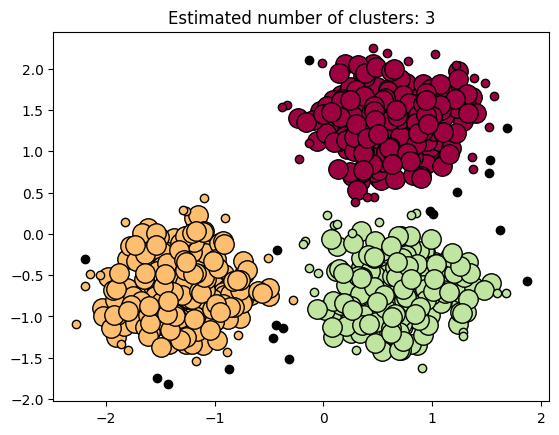

In [7]:
unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

# Demo of HDBSCAN clustering algorithm

In this demo we will take a look at cluster.HDBSCAN from the perspective of generalizing the cluster.DBSCAN algorithm. We’ll compare both algorithms on specific datasets. Finally we’ll evaluate HDBSCAN’s sensitivity to certain hyperparameters.

We first define a couple utility functions for convenience.

In [9]:
!pip install -q hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 30.1 MB/s eta 0:00:00


In [11]:
import matplotlib.pyplot as plt
import numpy as np

from hdbscan import HDBSCAN

#from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.datasets import make_blobs


def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

Generate sample data

One of the greatest advantages of HDBSCAN over DBSCAN is its out-of-the-box robustness. It’s especially remarkable on heterogeneous mixtures of data. Like DBSCAN, it can model arbitrary shapes and distributions, however unlike DBSCAN it does not require specification of an arbitrary and sensitive eps hyperparameter.

For example, below we generate a dataset from a mixture of three bi-dimensional and isotropic Gaussian distributions.

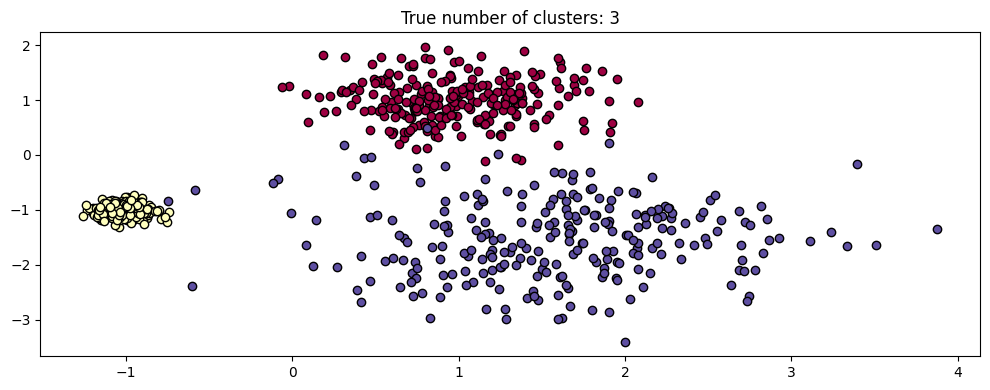

In [12]:
centers = [[1, 1], [-1, -1], [1.5, -1.5]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.4, 0.1, 0.75], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

Scale Invariance

It’s worth remembering that, while DBSCAN provides a default value for eps parameter, it hardly has a proper default value and must be tuned for the specific dataset at use.

As a simple demonstration, consider the clustering for a eps value tuned for one dataset, and clustering obtained with the same value but applied to rescaled versions of the dataset.

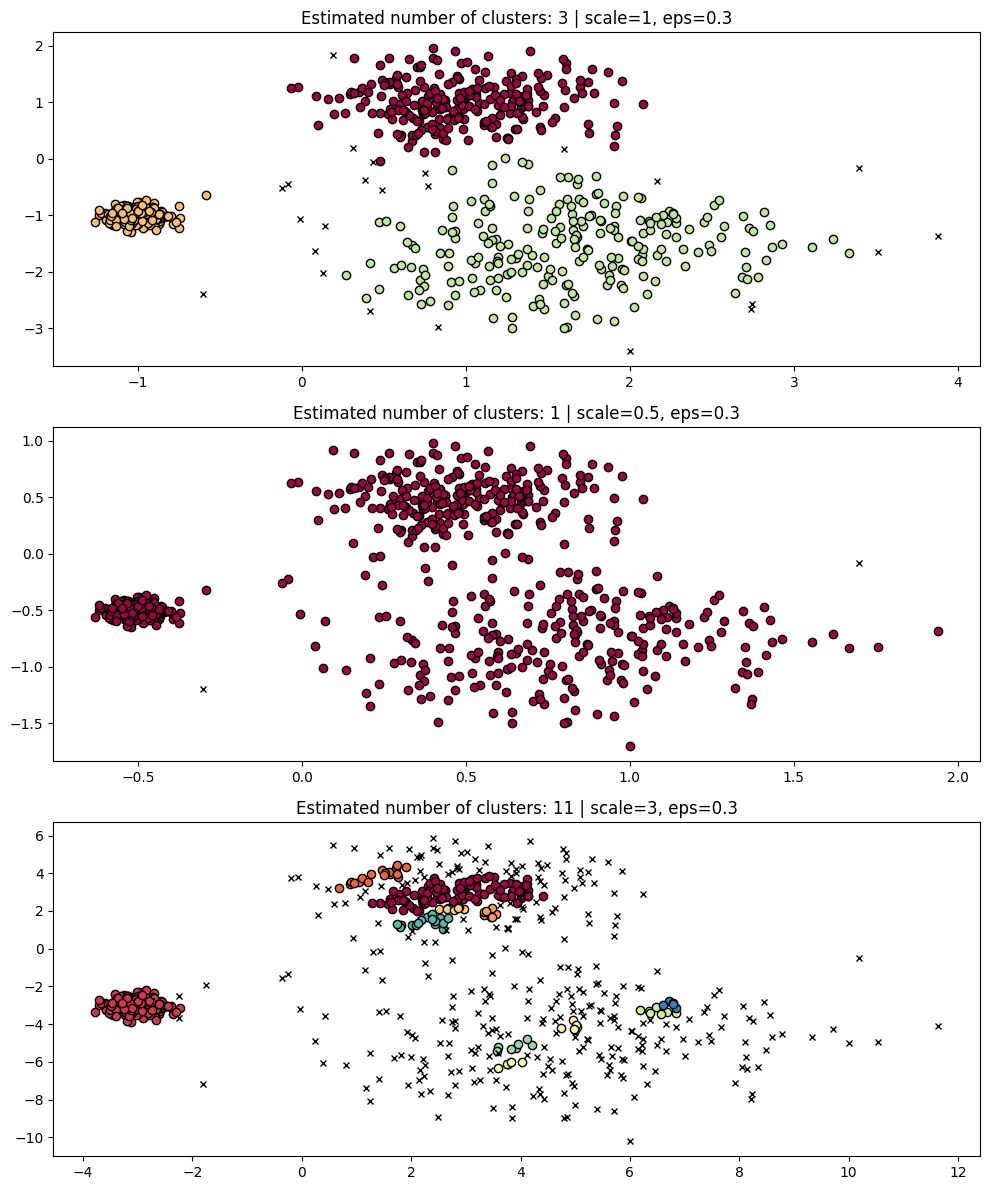

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
dbs = DBSCAN(eps=0.3)
for idx, scale in enumerate([1, 0.5, 3]):
    dbs.fit(X * scale)
    plot(X * scale, dbs.labels_, parameters={"scale": scale, "eps": 0.3}, ax=axes[idx])

Indeed, in order to maintain the same results we would have to scale eps by the same factor.



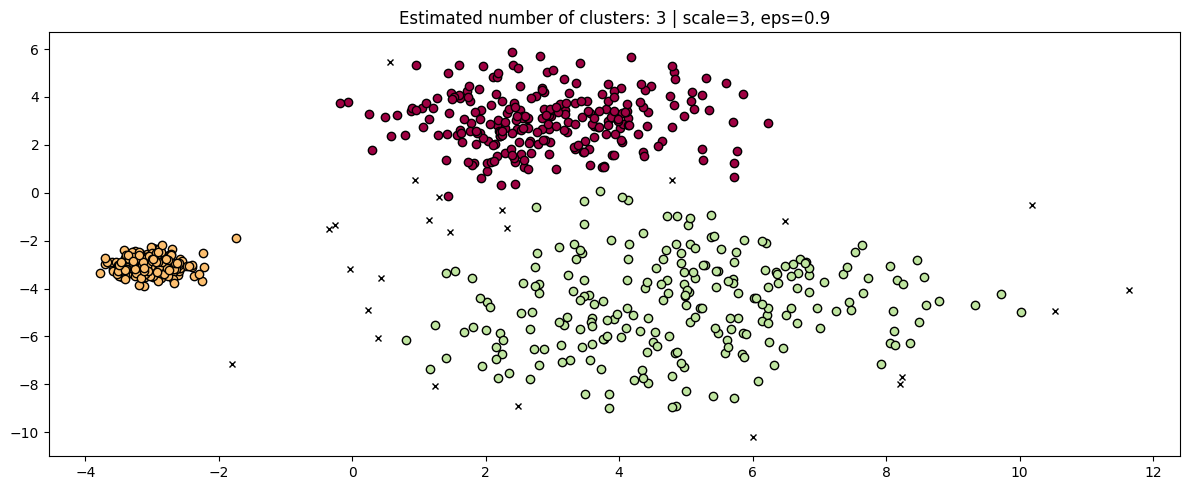

In [14]:
fig, axis = plt.subplots(1, 1, figsize=(12, 5))
dbs = DBSCAN(eps=0.9).fit(3 * X)
plot(3 * X, dbs.labels_, parameters={"scale": 3, "eps": 0.9}, ax=axis)

While standardizing data (e.g. using sklearn.preprocessing.StandardScaler) helps mitigate this problem, great care must be taken to select the appropriate value for eps.

HDBSCAN is much more robust in this sense: HDBSCAN can be seen as clustering over all possible values of eps and extracting the best clusters from all possible clusters (see User Guide). One immediate advantage is that HDBSCAN is scale-invariant.

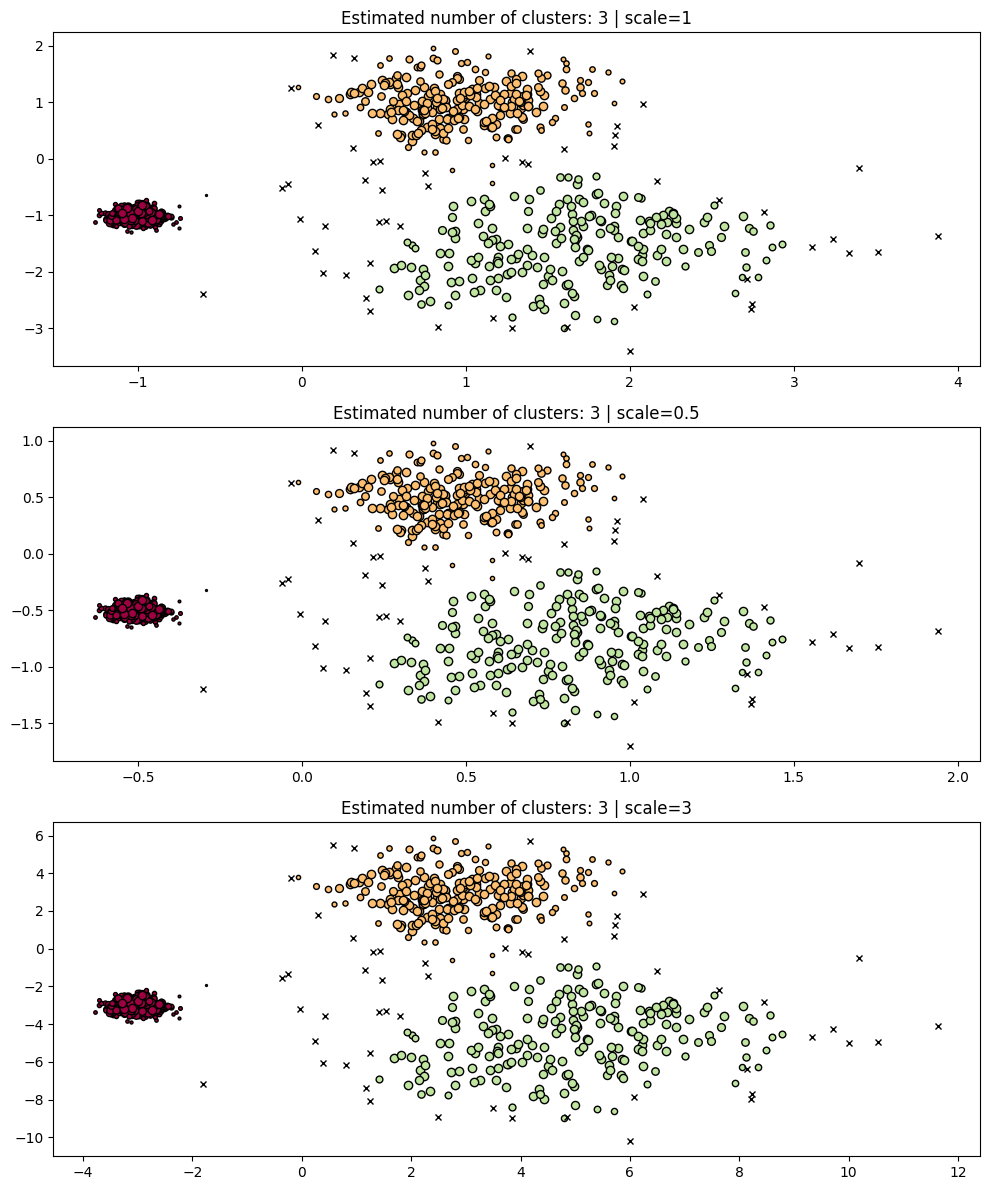

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
hdb = HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
    hdb.fit(X * scale)
    plot(
        X * scale,
        hdb.labels_,
        hdb.probabilities_,
        ax=axes[idx],
        parameters={"scale": scale},
    )

Multi-Scale Clustering

HDBSCAN is much more than scale invariant though – it is capable of multi-scale clustering, which accounts for clusters with varying density. Traditional DBSCAN assumes that any potential clusters are homogeneous in density. HDBSCAN is free from such constraints. To demonstrate this we consider the following dataset

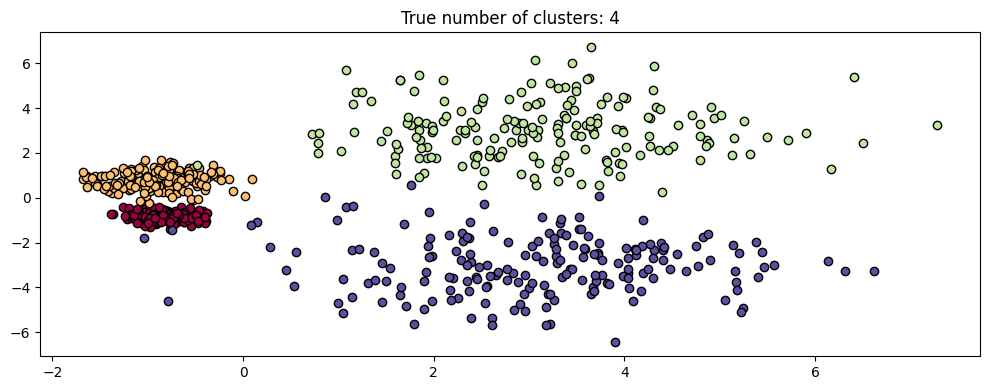

In [16]:
centers = [[-0.85, -0.85], [-0.85, 0.85], [3, 3], [3, -3]]
X, labels_true = make_blobs(
    n_samples=750, centers=centers, cluster_std=[0.2, 0.35, 1.35, 1.35], random_state=0
)
plot(X, labels=labels_true, ground_truth=True)

This dataset is more difficult for DBSCAN due to the varying densities and spatial separation:

- If eps is too large then we risk falsely clustering the two dense clusters as one since their mutual reachability will extend clusters.
- If eps is too small, then we risk fragmenting the sparser clusters into many false clusters.

Not to mention this requires manually tuning choices of eps until we find a tradeoff that we are comfortable with.

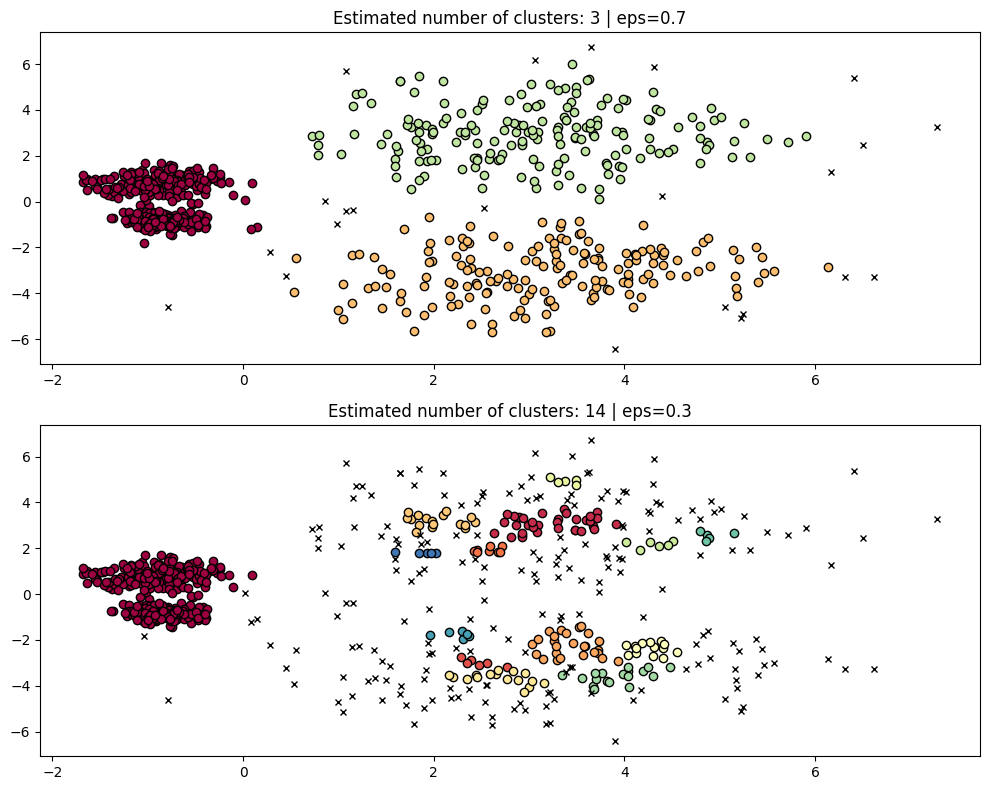

In [17]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))
params = {"eps": 0.7}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[0])
params = {"eps": 0.3}
dbs = DBSCAN(**params).fit(X)
plot(X, dbs.labels_, parameters=params, ax=axes[1])

To properly cluster the two dense clusters, we would need a smaller value of epsilon, however at eps=0.3 we are already fragmenting the sparse clusters, which would only become more severe as we decrease epsilon. Indeed it seems that DBSCAN is incapable of simultaneously separating the two dense clusters while preventing the sparse clusters from fragmenting. Let’s compare with HDBSCAN.



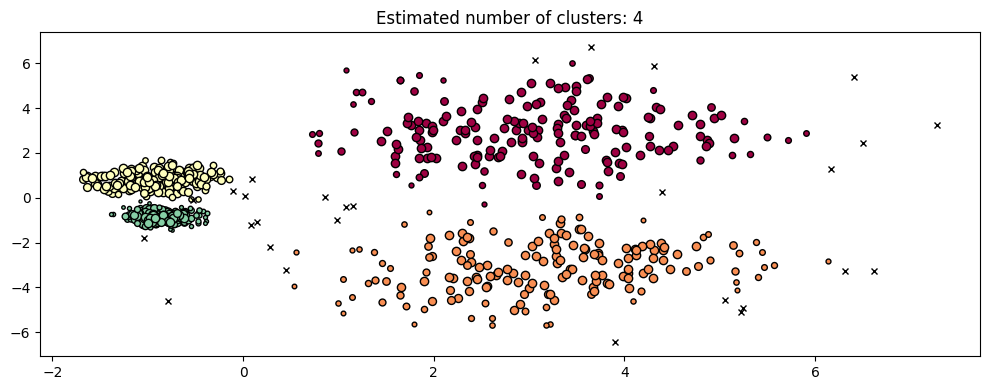

In [18]:
hdb = HDBSCAN().fit(X)
plot(X, hdb.labels_, hdb.probabilities_)

HDBSCAN is able to adapt to the multi-scale structure of the dataset without requiring parameter tuning. While any sufficiently interesting dataset will require tuning, this case demonstrates that HDBSCAN can yield qualitatively better classes of clusterings without users’ intervention which are inaccessible via DBSCAN.



## Hyperparameter Robustness

Ultimately tuning will be an important step in any real world application, so let’s take a look at some of the most important hyperparameters for HDBSCAN. While HDBSCAN is free from the eps parameter of DBSCAN, it does still have some hyperparameters like min_cluster_size and min_samples which tune its results regarding density. We will however see that HDBSCAN is relatively robust to various real world examples thanks to those parameters whose clear meaning helps tuning them.

min_cluster_size

min_cluster_size is the minimum number of samples in a group for that group to be considered a cluster.

Clusters smaller than the ones of this size will be left as noise. The default value is 5. This parameter is generally tuned to larger values as needed. Smaller values will likely to lead to results with fewer points labeled as noise. However values which too small will lead to false sub-clusters being picked up and preferred. Larger values tend to be more robust with respect to noisy datasets, e.g. high-variance clusters with significant overlap.

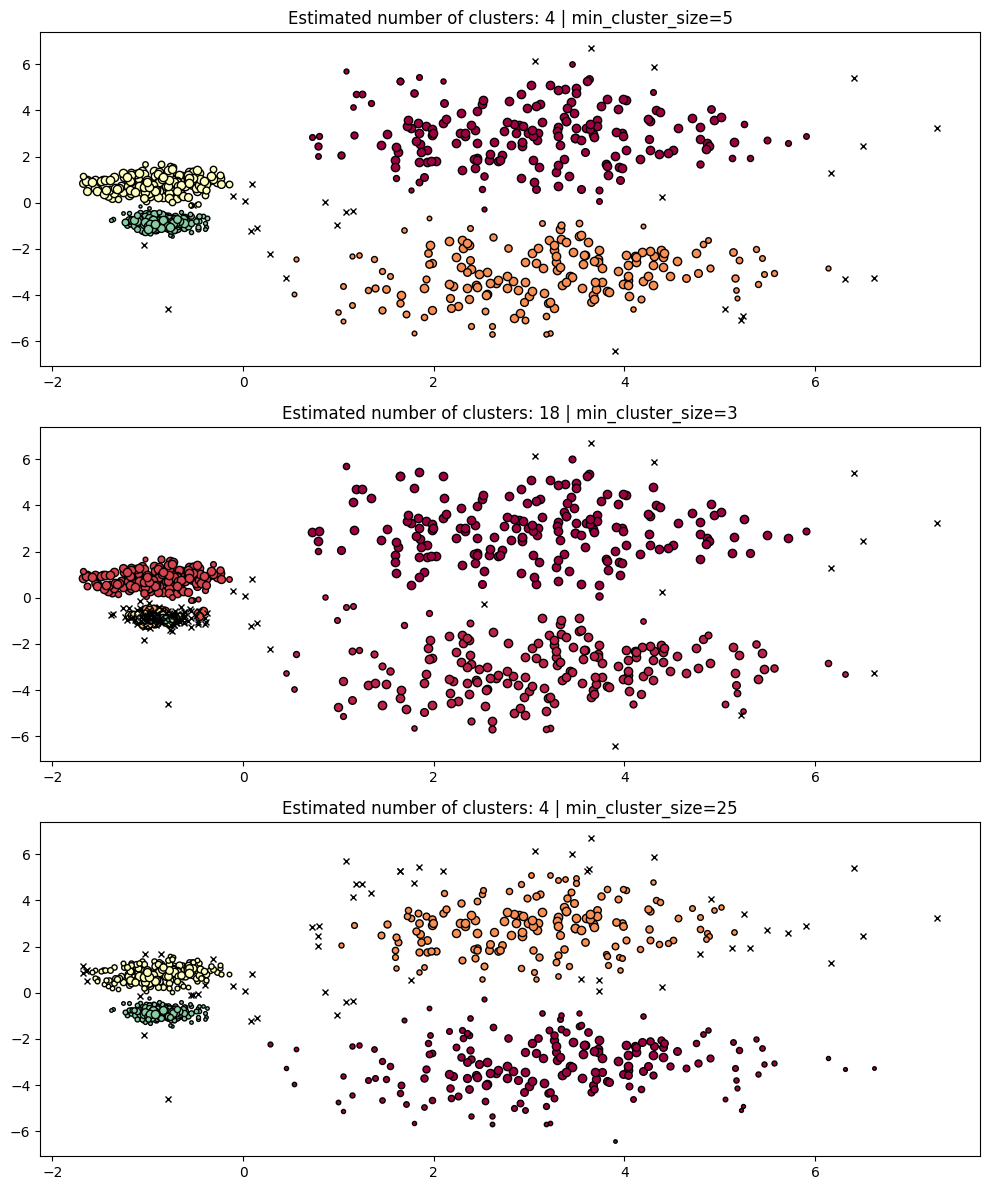

In [19]:
PARAM = ({"min_cluster_size": 5}, {"min_cluster_size": 3}, {"min_cluster_size": 25})
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(X)
    labels = hdb.labels_

    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

min_samples

min_samples is the number of samples in a neighborhood for a point to be considered as a core point, including the point itself. min_samples defaults to min_cluster_size. Similarly to min_cluster_size, larger values for min_samples increase the model’s robustness to noise, but risks ignoring or discarding potentially valid but small clusters. min_samples better be tuned after finding a good value for min_cluster_size.

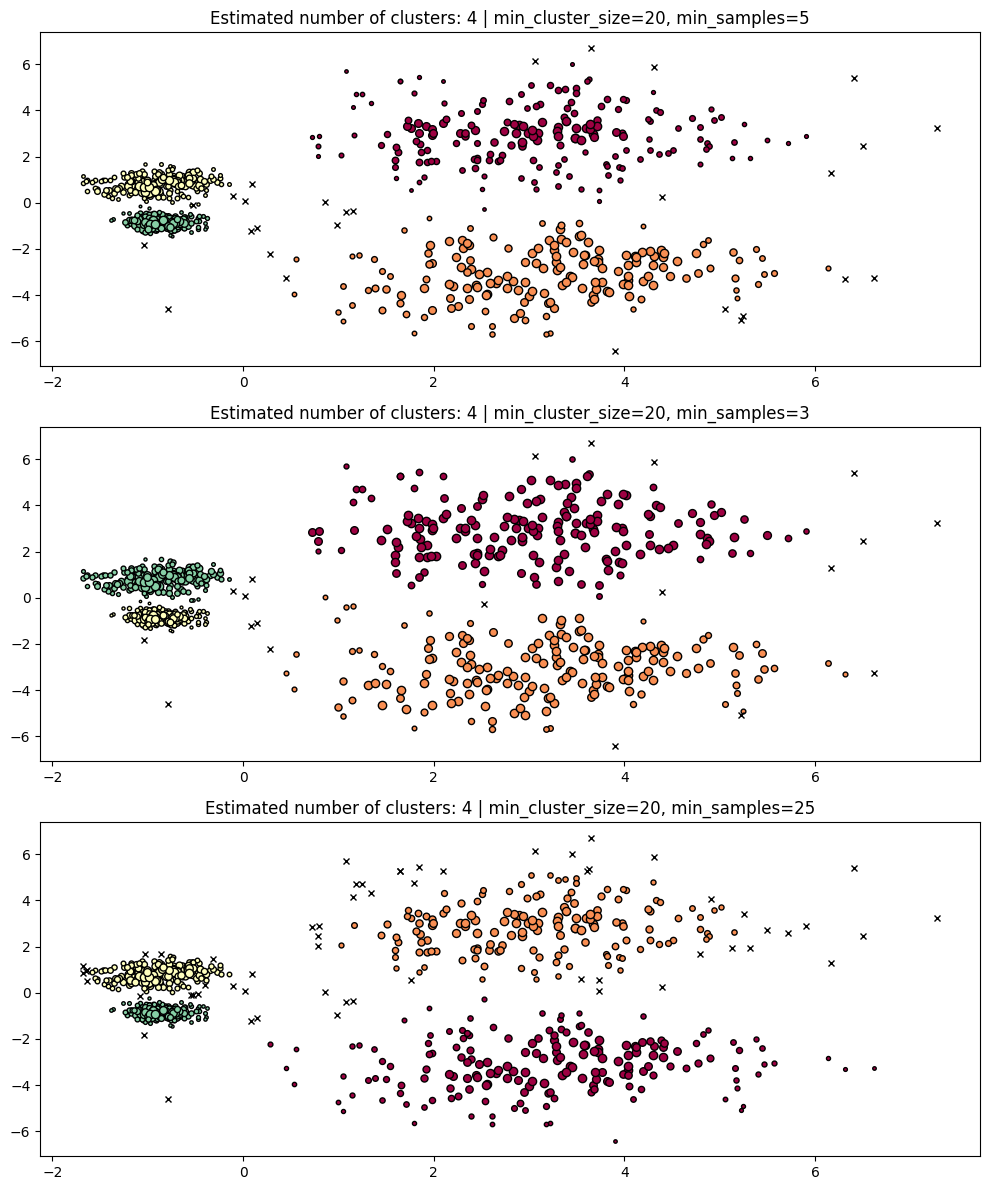

In [20]:
PARAM = (
    {"min_cluster_size": 20, "min_samples": 5},
    {"min_cluster_size": 20, "min_samples": 3},
    {"min_cluster_size": 20, "min_samples": 25},
)
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    hdb = HDBSCAN(**param).fit(X)
    labels = hdb.labels_

    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

dbscan_clustering

During fit, HDBSCAN builds a single-linkage tree which encodes the clustering of all points across all values of DBSCAN’s eps parameter. We can thus plot and evaluate these clusterings efficiently without fully recomputing intermediate values such as core-distances, mutual-reachability, and the minimum spanning tree. All we need to do is specify the cut_distance (equivalent to eps) we want to cluster with.

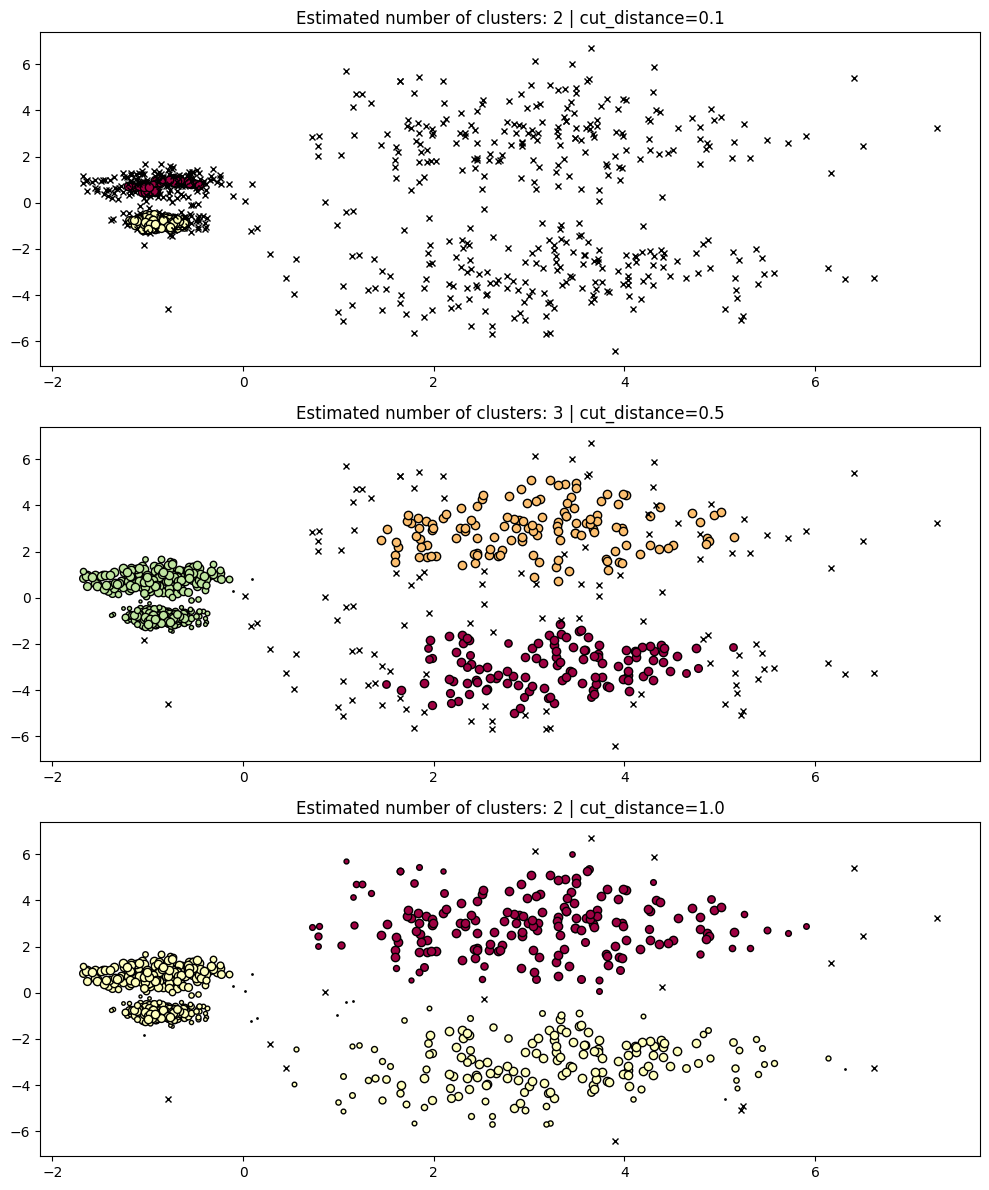

In [21]:
PARAM = (
    {"cut_distance": 0.1},
    {"cut_distance": 0.5},
    {"cut_distance": 1.0},
)
hdb = HDBSCAN()
hdb.fit(X)
fig, axes = plt.subplots(len(PARAM), 1, figsize=(10, 12))
for i, param in enumerate(PARAM):
    labels = hdb.dbscan_clustering(**param)

    plot(X, labels, hdb.probabilities_, param, ax=axes[i])

# Demo of OPTICS clustering algorithm

Finds core samples of high density and expands clusters from them. This example uses data that is generated so that the clusters have different densities.

The OPTICS is first used with its Xi cluster detection method, and then setting specific thresholds on the reachability, which corresponds to DBSCAN. We can see that the different clusters of OPTICS’s Xi method can be recovered with different choices of thresholds in DBSCAN.

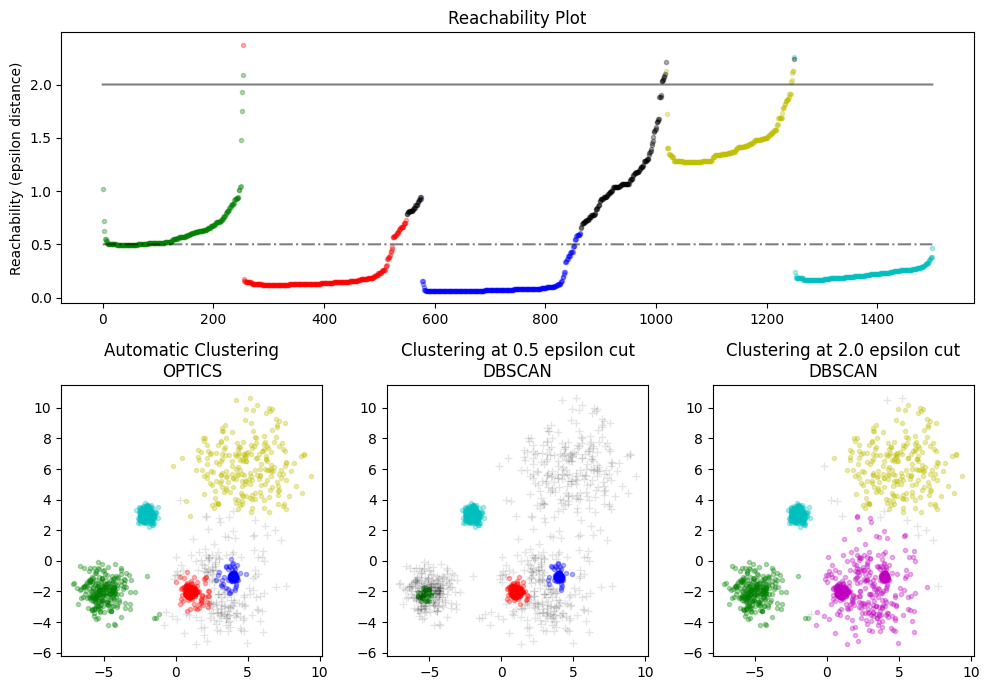

In [22]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import OPTICS, cluster_optics_dbscan

# Generate sample data

np.random.seed(0)
n_points_per_cluster = 250

C1 = [-5, -2] + 0.8 * np.random.randn(n_points_per_cluster, 2)
C2 = [4, -1] + 0.1 * np.random.randn(n_points_per_cluster, 2)
C3 = [1, -2] + 0.2 * np.random.randn(n_points_per_cluster, 2)
C4 = [-2, 3] + 0.3 * np.random.randn(n_points_per_cluster, 2)
C5 = [3, -2] + 1.6 * np.random.randn(n_points_per_cluster, 2)
C6 = [5, 6] + 2 * np.random.randn(n_points_per_cluster, 2)
X = np.vstack((C1, C2, C3, C4, C5, C6))

clust = OPTICS(min_samples=50, xi=0.05, min_cluster_size=0.05)

# Run the fit
clust.fit(X)

labels_050 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=0.5,
)
labels_200 = cluster_optics_dbscan(
    reachability=clust.reachability_,
    core_distances=clust.core_distances_,
    ordering=clust.ordering_,
    eps=2,
)

space = np.arange(len(X))
reachability = clust.reachability_[clust.ordering_]
labels = clust.labels_[clust.ordering_]

plt.figure(figsize=(10, 7))
G = gridspec.GridSpec(2, 3)
ax1 = plt.subplot(G[0, :])
ax2 = plt.subplot(G[1, 0])
ax3 = plt.subplot(G[1, 1])
ax4 = plt.subplot(G[1, 2])

# Reachability plot
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = space[labels == klass]
    Rk = reachability[labels == klass]
    ax1.plot(Xk, Rk, color, alpha=0.3)
ax1.plot(space[labels == -1], reachability[labels == -1], "k.", alpha=0.3)
ax1.plot(space, np.full_like(space, 2.0, dtype=float), "k-", alpha=0.5)
ax1.plot(space, np.full_like(space, 0.5, dtype=float), "k-.", alpha=0.5)
ax1.set_ylabel("Reachability (epsilon distance)")
ax1.set_title("Reachability Plot")

# OPTICS
colors = ["g.", "r.", "b.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[clust.labels_ == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax2.plot(X[clust.labels_ == -1, 0], X[clust.labels_ == -1, 1], "k+", alpha=0.1)
ax2.set_title("Automatic Clustering\nOPTICS")

# DBSCAN at 0.5
colors = ["g.", "r.", "b.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_050 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax3.plot(X[labels_050 == -1, 0], X[labels_050 == -1, 1], "k+", alpha=0.1)
ax3.set_title("Clustering at 0.5 epsilon cut\nDBSCAN")

# DBSCAN at 2.
colors = ["g.", "m.", "y.", "c."]
for klass, color in enumerate(colors):
    Xk = X[labels_200 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=0.3)
ax4.plot(X[labels_200 == -1, 0], X[labels_200 == -1, 1], "k+", alpha=0.1)
ax4.set_title("Clustering at 2.0 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()